# Lire les données

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("OneDrive\Documents\my_datasets\schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Lire dans les sondages

In [2]:
all_survey = pd.read_csv("OneDrive\Documents\my_datasets\schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("OneDrive\Documents\my_datasets\schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Ajouter des colonnes DBN

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convertir les colonnes en numérique

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condenser les ensembles de données

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convertir les scores AP en numérique

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combinez les ensembles de données

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Ajouter une colonne de district scolaire pour la cartographie

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Trouver des corrélations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Tracer les corrélations de l'enquête

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

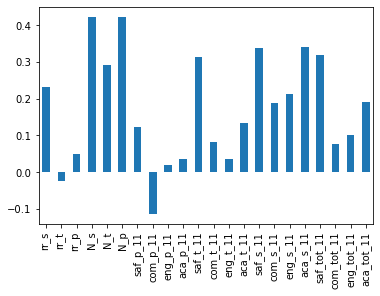

In [11]:
combined.corr()["sat_score"][survey_fields].plot.bar()

Il existe des corrélations élevées entre N_s, N_t, N_p et sat_score. Étant donné que ces colonnes sont corrélées à total_enrollment, il est logique qu'elles soient élevées.

Il est plus intéressant que rr_s, le taux de réponse des élèves ou le pourcentage d'élèves qui ont répondu à l'enquête, soit en corrélation avec sat_score. Cela peut avoir du sens, car les étudiants qui sont plus susceptibles de répondre à des sondages sont plus susceptibles de réussir également sur le plan scolaire.

Comment les élèves et les enseignants ont perçu la sécurité (saf_t_11 et saf_s_11) en corrélation avec sat_score. Cela a du sens, car il est difficile d'enseigner ou d'apprendre dans un environnement dangereux.

La dernière corrélation intéressante est l'aca_s_11, qui indique comment l'élève perçoit les normes académiques, est en corrélation avec sat_score, mais ce n'est pas vrai pour aca_t_11, comment les enseignants perçoivent les normes académiques, ou aca_p_11, comment les parents perçoivent les normes académiques.

# Explorer la sécurité

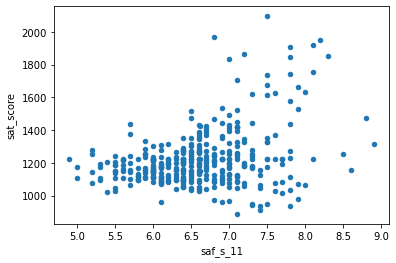

In [12]:
combined.plot.scatter(x='saf_s_11', y='sat_score')

Il semble y avoir une corrélation entre les scores SAT et la sécurité, bien que ce ne soit pas si fort. Il semble qu'il y ait quelques écoles avec des scores SAT extrêmement élevés et des scores de sécurité élevés. Il y a quelques écoles avec des scores de sécurité faibles et des scores SAT faibles. Aucune école avec un score de sécurité inférieur à 6,5 n'a un score SAT moyen supérieur à 1500 ou plus.

# Tracer la sécurité

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

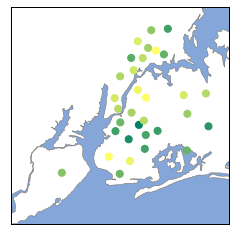

In [14]:
districts = combined.groupby("school_dist").agg(numpy.mean)
districts.reset_index(inplace=True)

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='f'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
# Temporary bug: if you run the following line of code in the Jupyter Guided Project interface on Dataquest, you'll get an error. 
# We're working on a fix, thanks for your patience! This should work fine locally on your own computer though.
m.fillcontinents(color='white',lake_color='#85A6D9')

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()
m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=districts["saf_s_11"], cmap="summer")
plt.show()

Il semble que l'Upper Manhattan et certaines parties du Queens et du Bronx ont tendance à avoir des scores de sécurité plus élevés, tandis que Brooklyn a de faibles scores de sécurité.

# Différences raciales dans les scores SAT

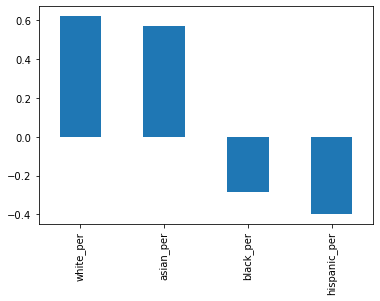

In [15]:
race_fields = ["white_per", "asian_per", "black_per", "hispanic_per"]
combined.corr()["sat_score"][race_fields].plot.bar()

Il semble qu'un pourcentage plus élevé d'étudiants blancs ou asiatiques dans une école soit en corrélation positive avec le score sat, tandis qu'un pourcentage plus élevé d'étudiants noirs ou hispaniques est en corrélation négative avec le score sat. Cela peut être dû à un manque de financement pour les écoles dans certaines régions, qui sont plus susceptibles d'avoir un pourcentage plus élevé d'élèves noirs ou hispaniques.

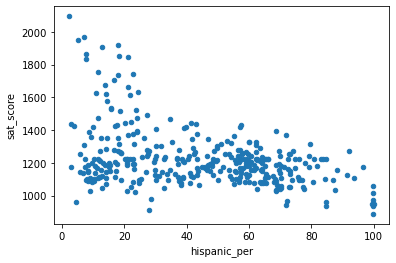

In [16]:
combined.plot.scatter("hispanic_per", "sat_score")

In [17]:
print(combined[combined["hispanic_per"] > 95]["SCHOOL NAME"])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


Les écoles énumérées ci-dessus semblent être principalement destinées aux immigrants récents aux États-Unis. Ces écoles ont beaucoup d'élèves qui apprennent l'anglais, ce qui expliquerait les scores SAT inférieurs.

In [18]:
print(combined[(combined["hispanic_per"] < 10) & (combined["sat_score"] > 1800)]["SCHOOL NAME"])

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


La plupart des écoles ci-dessus semblent être des écoles spécialisées en sciences et technologies qui reçoivent un financement supplémentaire et n'acceptent que les étudiants qui réussissent un examen d'entrée. Cela n'explique pas le faible hispanic_per, mais cela explique pourquoi leurs étudiants ont tendance à faire mieux au SAT - ce sont des étudiants de partout dans la ville de New York qui ont bien réussi un test standardisé.

# Différences entre les sexes dans les scores SAT

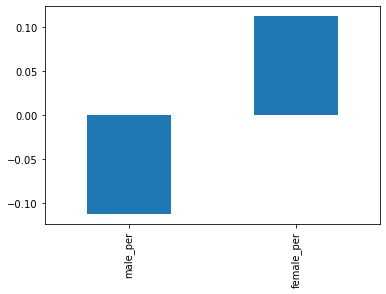

In [19]:
gender_fields = ["male_per", "female_per"]
combined.corr()["sat_score"][gender_fields].plot.bar()

Dans le graphique ci-dessus, nous pouvons voir qu'un pourcentage élevé de filles dans une école est en corrélation positive avec le score SAT, alors qu'un pourcentage élevé d'hommes dans une école est en corrélation négative avec le score SAT. Aucune des deux corrélations n'est extrêmement forte.

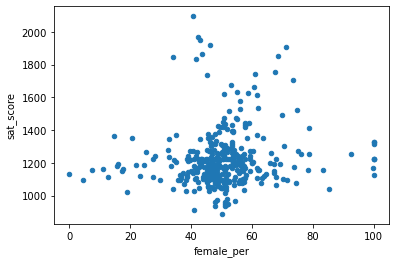

In [20]:
combined.plot.scatter("female_per", "sat_score")

Sur la base du nuage de points, il ne semble pas y avoir de réelle corrélation entre sat_score et female_per. Cependant, il existe un groupe d'écoles avec un pourcentage élevé de filles (60 à 80) et des scores SAT élevés.

In [21]:
print(combined[(combined["female_per"] > 60) & (combined["sat_score"] > 1700)]["SCHOOL NAME"])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


Ces écoles semblent être des écoles d'arts libéraux très sélectives qui ont des normes académiques élevées.

# Scores d'examen AP vs scores SAT

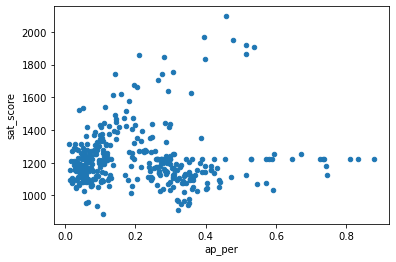

In [22]:
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]

combined.plot.scatter(x='ap_per', y='sat_score')

Il semble qu'il existe une relation entre le pourcentage d'élèves d'une école qui passent l'examen AP et leurs scores SAT moyens. Ce n'est pas une corrélation extrêmement forte, cependant.